In [0]:
import numpy as np
import itertools

In [0]:
num_pulleys=4

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Representation used for this code development ###

![](https://github.com/Machine-Learning-Tokyo/Agritech/blob/muru/Suspended_Robot/ML4D/string_coordinate_representation_img_1.JPG?raw=1)

#### `get_li` ####

For getting inital $L_i$, we assume that the bot is at the `top-center`. With this assumption, we only need to consider `B & D` metrics for calculating $L_i$



In [0]:
def get_Li(B, D):
    """
    The inital length of strings based on B and D
    """
    return 0.5*np.sqrt(B**2 + D**2)

### TODO
 - [ ] We need to account for 360 degree rotation here
    - Are you talking about the decrease in radius each time the pulley rotates completely?
 - [x] We need to have a reverse calculation done, i.e. given a $x_i,y_i,z_i$ & $x_f,y_f,z_f$ we need to find out what the inital and final thetas. But more on that later.

#### `get_final_string_length` ####
Considering that we have an inital length available, `delta_thetas` given, this function would provide what would be the final length if the pulleys are moved by `delta_theta`

$$ L_f = L_i + r_i\Delta\theta_i $$

#### `get_theta_from_string_length` ####
If we have final length $L_f$ and inital string length $L_i$ and the radius of the pulleys, then we can find the `delta_thetas` moved by the pulleys

<h4 style="color:red">NOTE</h4>
Remember, $L_i$ and & $L_f$ are array/list, so the output would also be array/list each corresponding to individual pulleys.

In [0]:
def get_final_string_length(Li, r, delta_thetas=np.zeros((1,num_pulleys))):
    """
    The final length of strings which need to be achieved for 
    reaching a specific location (based on thetas).
    """
    return Li + r*delta_thetas

def get_theta_from_string_length(Lf, Li, r):
    """
    Given some string lengths Lf and initial lengths Li, return
    the rotation of the pulleys
    """
    return (Lf - Li)/r

#### `get_coordinate` ####
Assumption:
We start from the top of the board, therefore the $L_i$ is same for all strings

1. We take the initial $L_i$ for all strings
2. We are given the `thetas` that the pulley moved
3. We use initial $L_i$ and `thetas` to get final lengths

Then we use following formulas for getting coordinates of the final place the bot moved to

\begin{align}
y &= \frac{l_1^2 - l_2^2 + D^2}{2D} \\
x &= \frac{l_2^2 - l_3^2 + B^2}{2B}
\end{align}

\begin{aligned}
l_1^2 &= (0 - x)^2 + (0 - y)^2 + (H - z)^2 \\ &= x^2 + y^2 + (H - z)^2
\end{aligned}

\begin{aligned}
(H - z)^2 = l_1^2 - x^2 - y^2\\
\end{aligned}

$(H - z)^2$ = Hz2 (Python variable)


In [0]:
def get_coordinate(thetas, B, D, H, r):
    """
    thetas: numpy array of rotations, shape: (num_arrays, )
    B, D, H, r: scalar constants
    """
    Li = get_Li(B, D)
    l = get_final_string_length(Li, r, thetas)
    x = (l[1]**2 - l[2]**2 + B**2)/(2*B)
    y = (l[0]**2 - l[1]**2 + D**2)/(2*D)
    Hz2 = l[0]**2 - x**2 - y**2 # (H-z)^2, eqn 1
    # Is it taut?
    # print(l[0]**2 - l[3]**2, l[1]**2 - l[2]**2)
    z = H - np.sqrt(Hz2)
    return np.array([x, y, z])

### `get_thetas` ###
<p style="color:red">We assume that we always start from the `top` center of the construct that you see on the top.</p>

With the above assumption, the inital length of strings would be taken from `get_Li(B,D)` function.
If we are given the final co-ordinates (x,y,z), we can fund the $Lf$ using following formulas

\begin{align}
\begin{aligned}
l_1^2 &= x^2 + y^2 + (H - z)^2
\end{aligned} \\
\begin{aligned}
l_2^2 &= x^2 + (D - y)^2 + (H - z)^2
\end{aligned} \\
\begin{aligned}
l_3^2 &= (B - x)^2 + (D - y)^2 + (H - z)^2
\end{aligned} \\
\begin{aligned}
l_4^2 &= (B - x)^2 + y^2 + (H - z)^2
\end{aligned} \\
\end{align}

python variable $Hz2 = (H - Z)^2$

In [0]:
def get_thetas(coords, B, D, H, r, back_home=False):
    """
    coords: (x, y, z) coordinates
    B, D, H, r: scalar constants
    """
    l = np.zeros((4,))
    x, y, z = coords
    Hz2 = (H - z)**2 # common term
    l[0] = np.sqrt(x**2 + y**2 + Hz2)
    l[1] = np.sqrt(x**2 + (D - y)**2 + Hz2)
    l[2] = np.sqrt((B - x)**2 + (D - y)**2 + Hz2)
    l[3] = np.sqrt((B - x)**2 + y**2 + Hz2)
    if back_home:
        return get_theta_from_string_length(get_Li(B, D),l, r)
    else:
        return get_theta_from_string_length(l, get_Li(B, D), r)

In [0]:
# Box dimensions
B, D, H = 100, 200, 300
# Pulley radius
r = 0.1
# Pulley locations
Pulleys = [(0, 0, H), (0, D, H), (B, D, H), (B, 0, H)]

Taking some random values of $\Theta$, we can get the corresponding coordinates from `get_coordinates()`.
If $\Theta$ is such that the ropes are taught, we will get back the original $\Theta$ from `get_thetas()`.
If they aren't, the values will be different. Both are demonstrated in the following example. In the first case, $\theta_4$ is clearly different from the value we set, but in the second case, all angles are exactly the same.

### Below is just a cross-check function. ###
1. Each pulley rotated `[10,20,30,40]` rotations respectively, (i.e 1st pulley, 2nd pulley etc.)
2. With these rotations we get the final co-ordinates, remember we assume we start from top of the structure area.
3. While using the final_cordinates we use `get_thetas` function, i.e how much theta is supposed to be moved, this should come back to thetas we decided earlier.

In [9]:
def display(rotations, coords, theta):
    print(f'For rotation = {rotations/(2*np.pi)}')
    x, y, z = coords
    print(f'\tx = {x}, y = {y}, z = {z}')
    print('\tΘ = ', theta)
    print()
    
# Pulleys rotated 10 revolutions, 20, 30, and 40, respectively
rotations = np.array([10, 20, 30, 40])*2*np.pi
coords = get_coordinate(rotations, B, D, H, r)
theta = get_thetas(coords, B, D, H, r)/(2*np.pi)
display(rotations, coords, theta)

# Pulleys rotated 10 revolutions, 20, 20, and 10, respectively
rotations = np.array([10, 20, 20, 10])*2*np.pi
coords = get_coordinate(rotations, B, D, H, r)
theta = get_thetas(coords, B, D, H, r)/(2*np.pi)
display(rotations, coords, theta)

For rotation = [10. 20. 30. 40.]
	x = 41.98822482885034, y = 96.19150450244695, z = 245.88322994588324
	Θ =  [10.        20.        30.        20.5045589]

For rotation = [10. 20. 20. 10.]
	x = 50.0, y = 96.19150450244695, z = 253.18508971098808
	Θ =  [10. 20. 20. 10.]



As we know that all points are calculated from Top, therefore, we need to 2 sets to data.
1. Move from base $(B/2,D/2,H)$ to the target location
2. Move from some location back to $(B/2,D/2,H)$

In this case, we are looking at a dataset which looks like this

|$X_i$|$Y_i$|$Z_i$|$X_f$|$Y_f$|$Z_f$| B | D | H | r |theta_0|theta_1|theta_2|theta_3|
|-----|-----|-----|-----|-----|-----|---|---|---|---|-------|-------|-------|-------|

In [10]:
B = D = H = np.arange(1,7,0.5)
r = [0.008]

data = np.zeros((1,11))
first=True
element = 0
for b,d,h,r in itertools.product(B,D,H,r):
    x_range = np.arange(0,b,1)
    y_range = np.arange(0,d,1)
    z_range = np.arange(0,h,1)
    for x,y,z in itertools.product(x_range,y_range,z_range):
        thetas_from_home = get_thetas([x,y,z],B=b,D=d,H=h,r=r,back_home=False)
        if first:
            data = np.array([x,y,z,b,d,h,r,thetas_from_home[0],thetas_from_home[1],thetas_from_home[2],thetas_from_home[3]])
            first=False
        else:
            data = np.vstack((data,np.array([x,y,z,b,d,h,r,thetas_from_home[0],thetas_from_home[1],thetas_from_home[2],thetas_from_home[3]])))
            first = False
    if (element+1) % 100 == 0:
        print("Shape : ",data.shape)
    if (element+1) % 1000 == 0:
        print("Completed with %d / %d" %(element+1, 5000))
    element += 1

Shape :  (1192, 11)
Shape :  (3216, 11)
Shape :  (7008, 11)
Shape :  (9792, 11)
Shape :  (13392, 11)
Shape :  (18864, 11)
Shape :  (23616, 11)
Shape :  (28608, 11)
Shape :  (35520, 11)
Shape :  (42656, 11)
Completed with 1000 / 5000
Shape :  (48936, 11)
Shape :  (57216, 11)
Shape :  (66864, 11)
Shape :  (74448, 11)
Shape :  (83808, 11)
Shape :  (94912, 11)
Shape :  (105216, 11)


In [11]:
data.shape

(110592, 11)

In [0]:
import pandas as pd
data_df = pd.DataFrame(data,columns=["x_f","y_f","z_f","b","d","h","r","theta0","theta1","theta2","theta3"])

In [13]:
data_df.apply(lambda x : x.unique().shape)

x_f          (7,)
y_f          (7,)
z_f          (7,)
b           (12,)
d           (12,)
h           (12,)
r            (1,)
theta0    (6678,)
theta1    (9539,)
theta2    (6681,)
theta3    (9539,)
dtype: object

In [14]:
data_df.head(2)

,x_f,y_f,z_f,b,d,h,r,theta0,theta1,theta2,theta3
0,0.0,0.0,0.0,1.0,1.0,1.0,0.008,36.611652,88.388348,128.118003,88.388348
1,0.0,0.0,0.0,1.0,1.0,1.5,0.008,99.111652,136.958607,169.305754,136.958607


Lets verify whether the thetas calculated are correct, by reverse calculated the $x_f,y_f,z_f$ using the theta values

In [15]:
idx = 10
print(get_coordinate(thetas = data_df.iloc[idx,[-4,-3,-2,-1]],
                     B = data_df.iloc[idx,]["b"],
                     D = data_df.iloc[idx,]["d"],
                     H = data_df.iloc[idx,]["h"],
                     r=0.008))
print(data_df.iloc[idx,[0,1,2]].values)

[ 4.44089210e-16 -2.22044605e-16  2.00000000e+00]
[0. 0. 2.]


In [0]:
data_df.to_csv("suspended_robot_data_r_0.008_B_D_H_1_6_20190826.csv",header=True,index=False)

In [0]:
data_df_model = data_df.copy()

In [0]:
import matplotlib.pyplot as plt

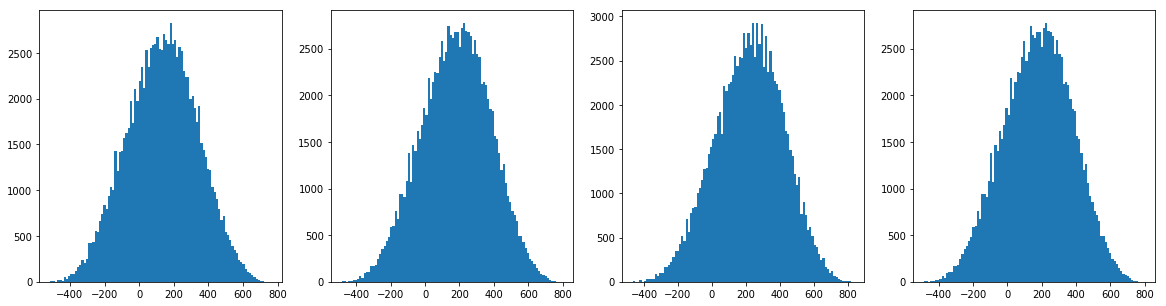

In [23]:
fig, ax = plt.subplots(nrows=1,ncols=4,sharex=False,sharey=False,figsize=(20,5))
ax[0].hist(data_df_model.theta0,bins=100)
ax[1].hist(data_df_model.theta1,bins=100)
ax[2].hist(data_df_model.theta2,bins=100)
ax[3].hist(data_df_model.theta3,bins=100)
plt.show()

In [0]:
from sklearn.preprocessing import StandardScaler

In [26]:
obj = StandardScaler()
obj.fit(data_df_model[["theta0","theta1","theta2","theta3"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
import pickle
with open("Y_theta_value_scalar_1X4_format.pkl","wb") as f:
    pickle.dump(obj,f)

In [0]:
data_df_model_2 = pd.concat([data_df_model.drop(columns=["theta0","theta1","theta2","theta3"],inplace=False),
                             pd.DataFrame(obj.transform(data_df_model[["theta0","theta1","theta2","theta3"]]),columns=["scaled_theta0","scaled_theta1","scaled_theta2","scaled_theta3"])],axis=1)

In [29]:
data_df_model_2.head()

,x_f,y_f,z_f,b,d,h,r,scaled_theta0,scaled_theta1,scaled_theta2,scaled_theta3
0,0.0,0.0,0.0,1.0,1.0,1.0,0.008,-0.487743,-0.452308,-0.461088,-0.452308
1,0.0,0.0,0.0,1.0,1.0,1.5,0.008,-0.176528,-0.208896,-0.253446,-0.208896
2,0.0,0.0,1.0,1.0,1.0,1.5,0.008,-0.798957,-0.637847,-0.607318,-0.637847
3,0.0,0.0,0.0,1.0,1.0,2.0,0.008,0.134686,0.062536,-0.008981,0.062536
4,0.0,0.0,1.0,1.0,1.0,2.0,0.008,-0.487743,-0.452308,-0.461088,-0.452308


In [0]:
data_df_model_2.to_csv("suspended_robot_data_all_scaled_r_0.008_B_D_H_1_6_20190826.csv",header=True,index=False)

In [0]:
X_df = data_df_model_2.drop(columns=["r","scaled_theta0","scaled_theta1","scaled_theta2","scaled_theta3"],inplace=False)
Y_df = data_df_model_2[["scaled_theta0","scaled_theta1","scaled_theta2","scaled_theta3"]]

In [0]:
X_df.to_csv("suspended_robot_X_data_df.csv",header=True,index=False)
Y_df.to_csv("suspended_robot_Y_data_df.csv",header=True,index=False)

In [0]:
X = data_df_model_2.drop(columns=["r","scaled_theta0","scaled_theta1","scaled_theta2","scaled_theta3"],inplace=False).values
Y = data_df_model_2[["scaled_theta0","scaled_theta1","scaled_theta2","scaled_theta3"]].values

In [35]:
X.shape,Y.shape

((110592, 6), (110592, 4))

In [0]:
X.dump("suspended_robot_X_data.npy")
Y.dump("suspended_robot_Y_data.npy")